<a href="https://colab.research.google.com/github/kmaranga/AI/blob/main/Shapley_California_Housing_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import shap

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [19]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from scipy.spatial import cKDTree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.datasets import fetch_california_housing


In [20]:
#use the California Housing public dataset to predict median house value
#dataset has 20,640 records and 8 columns
housing = fetch_california_housing(as_frame=True)
print(housing.data.shape, housing.target.shape)
print(housing.DESCR)

(20640, 8) (20640,)
.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, 

In [21]:
housing.frame.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [22]:
housing.data.head(10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25


In [23]:
housing.target.head() #some info on the target val to be predicted

,MedHouseVal
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422


In [24]:
#check for missing values
housing.frame.info()
#no missing values! hooray!!!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [25]:
X, y_ = shap.datasets.california()

In [27]:
#create a new variable, "spatial_density" using lat and long to capture geographic distribution of houses
spatial = cKDTree(X[["Latitude", "Longitude"]])
X["spatial_density"] = spatial.query_ball_point(X[["Latitude", "Longitude"]], 0.005, return_length = True)

In [40]:
#drop lat and long columns afterwards to prevent potential bias
#transform target var(median value) using a log func to stabilise variance and improve model performance
y = pd.DataFrame(np.log(y_), columns = ["target"])
x_train, x_test, y_train, y_test = train_test_split(X.drop(columns = ["Latitude", "Longitude"]), y, test_size = 0.1, random_state = 42)
#housing.frame.head()
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,spatial_density
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,1
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,1
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,4
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3


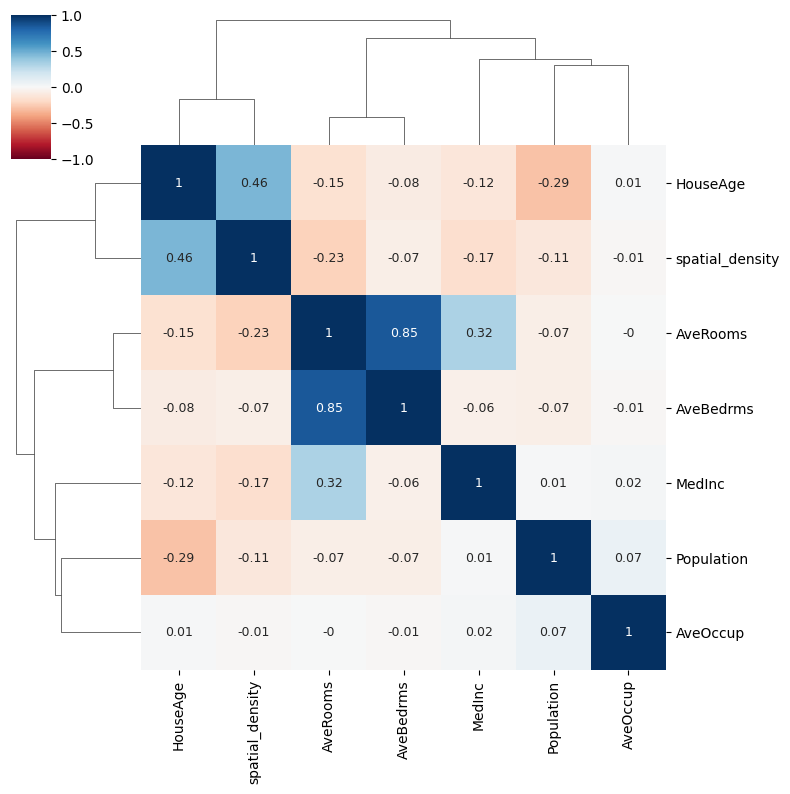

In [41]:
#since certain features have certain inherent relationships, we anticipate forming feature coalitions
#e.g AveBedrms and AveRooms are strongly correlated as they resonate with avg house sizes.
#features like MedInc and Population on the other hand are less correlated(more independent) as areas with high
#populations don't necessarily have higher/lower median incomes - think NYC vs Martha's Vineyard?

#Feature correlation
sns.clustermap(
    round(x_train.corr(), 2), method = "complete", cmap = "RdBu",
    annot = True, annot_kws = {"size":9}, vmin = -1, vmax = 1, figsize = (8,8)
)

In [42]:
#Part 2: Using a two-level stacking ensemble model with 2 decison trees as base learners and a linear regression model
#as the meta learner - to try and improve accuracy/reduce loss/MSE
params_base_learner1 = {"max_depth" :3, "random_state":42}
params_base_learner2 = {"max_depth":7, "random_state":42}

base_learner1 = DecisionTreeRegressor(**params_base_learner1)
base_learner2 = DecisionTreeRegressor(**params_base_learner2)
meta_learner = LinearRegression()

base_estimators = [("dt1", base_learner1), ("dt2", base_learner2)]


In [43]:
model = StackingRegressor(
    estimators = base_estimators, final_estimator = meta_learner,
    cv = 5, n_jobs = -1, verbose = 5,
)
model.fit(x_train, np.ravel(y_train))

StackingRegressor(cv=5,
                  estimators=[('dt1',
                               DecisionTreeRegressor(max_depth=3,
                                                     random_state=42)),
                              ('dt2',
                               DecisionTreeRegressor(max_depth=7,
                                                     random_state=42))],
                  final_estimator=LinearRegression(), n_jobs=-1, verbose=5)

In [44]:
model.score(x_test, y_test)

0.618179360656354

In [46]:
model.score(x_train, y_train)

0.6671925869744555

In [49]:
base_learner1.score(x_test, y_test)

#base_learner2.score(x_test, y_test)

0.5029110189472339

In [50]:
base_learner2.score(x_test, y_test)

0.6151767489878577

In [51]:
#model MSE - CLEARLY BETTER AS AN ENSEMBLE THAN THE 2 SEPARATE TREES!!
mean_squared_error(y_test, model.predict(x_test))

0.12491080782044917

In [52]:
#base_learner1 MSE
mean_squared_error(y_test, base_learner1.predict(x_test))

0.16262029807681808

In [54]:
#base_learner2 MSE
mean_squared_error(y_test, base_learner2.predict(x_test))

0.12589309795994424

  0%|          | 0/500 [00:00<?, ?it/s]

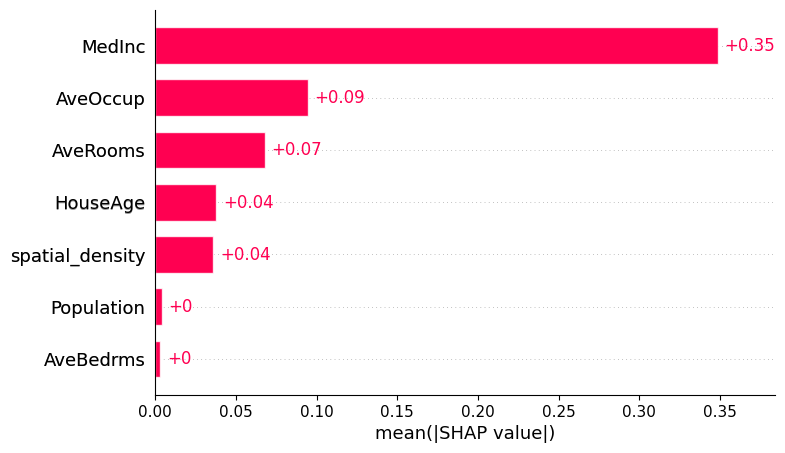

In [55]:
#shapley values, understanding individual contributions
#a method from cooperative game theory helping us measure each feature's individual contribution to the model prediction
#the model prediction could be viewed as a "reward" that needs to be fairly distributed to the players"features" and by calculating
#Shapley values, we can see how predictions change by the inclusion or exclusion of certain features from a subset of features
#i.e captures the marginal contribution of each feature.
#The Shapley value for a feature is calculated by averaging its marginal contributions across all possible subsets of features
#use MonteCarlo sampling due to computational complexity issues to randomly sample subsets of features rather than all subsets

#Hoeffding's inequality helps provide a statistical guarantee by evaluating how close Shapley values estimated through
#sampling are to the true values by bounding the probability that sampled Shapley-values will deviate from actual
#Shapley values by no more than a specified amount.

#For a sufficiently large number of samples, the probability that our estimated Shapley values deviate from the actual
#value by more than a small margin of erro becomes very small. (Increase K(no. samples), decrease probability of significant error)

#Hoeffding's inequality helps us choose a suitable sample size for acceptable accuracy.

#Using Shap's KernelExplainer for our California Housing DataSet:
#KernelExplainer however IGNORES dependencies between features(i.e assumes independence),
#even correlated ones as it uses marginal sampling rather than conditional sampling.

K = 2520 #from Hoeffding with p = 7, a = -2, b = 2, alpha = 0.01, epsilon = 0.1

background_data = shap.sample(x_train, K, random_state = 0)
fn = lambda x: model.predict(pd.DataFrame(x, columns = list(x_train.columns)))
explainer = shap.KernelExplainer(fn, background_data, link = 'identity')
#shap_values = explainer.shap_values(x_test, nsamples = 100)
shap_values = explainer(x_test.sample(500, random_state = 37))

shap.plots.bar(shap_values)

In [56]:
#Owen values - an extension of Shapley values; accounting for feature interactions
#allow the formation of coalitions of features that act together

'''
Steps: 1. Form coalitions based on related features - e.g AveRooms and AveBedrms
2. Treat each coalition as a "single player" in the cooperative game, calculating the
Shapley value for each coalition
3. Finally, within each coalition, distribute the ccoalition's Shapley value among
individual features based on their individual contribution to the coalition.

- By first calculating Shapley values for coalitions and then distributinf within
the coalition ensures Owen values accurately reflect both individual and collective
contributions to the model prediction, especially when features are interdependent.

- By clustering correlated features into groups, we can create coalitions that
better reflect real-world dependencies, capturing their collective influence.

'''
dist = 1 - np.abs(x_train.corr()) #create the distance matrix
condensed = squareform(dist)
clust = shap.utils.hclust(x_train, metric = "correlation")
#or clust = sch.linkage(condensed, method = 'complete')


PartitionExplainer explainer: 251it [00:10,  2.55it/s]


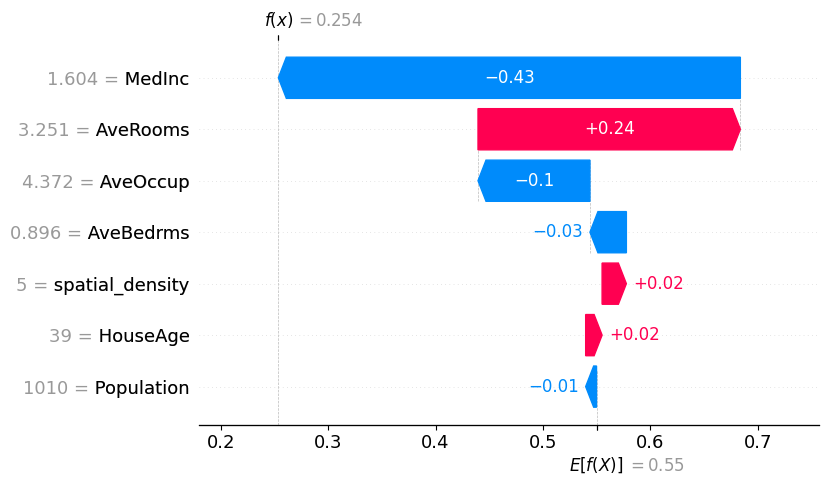

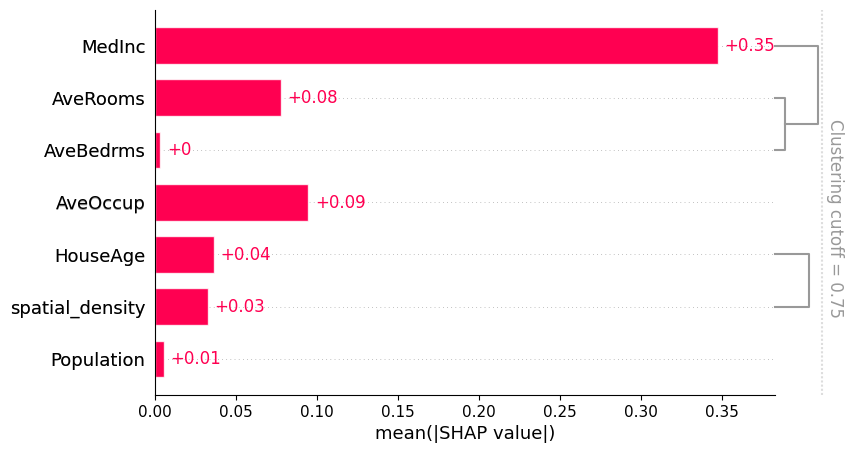

In [57]:
#next, specify feature groups for the PartitonExplainer through the clustering parameter
masker = shap.maskers.Partition(x_train, clustering = clust)
part_explainer = shap.PartitionExplainer(fn, masker)
shap_vals_part = part_explainer(x_test.sample(250, random_state = 37)) #reduced from 500 sample size for faster computation
shap.plots.waterfall(shap_vals_part[0])
shap.plots.bar(shap_vals_part, clustering_cutoff = 0.75)
